In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

N = [30, 100, 300]
D = 0.02        # en cm
rho_0 = 1e-5    # en C/m^3
Va = 0          # ambos V en Volts
Vb = 10
e_0 = 8.85e-12  # permisividad del vacío

def gauss_elimination(N, method = "standard"):
  h = D / (N + 1)

  x = np.linspace(h, D-h, N)
  rho = rho_0 * np.sin(np.pi * x / D)
  f = -rho / e_0
  fh2 = f * h**2
  fh2[0] -= Va
  fh2[-1] -= Vb

  # Construimos la matriz tridiagonal A
  A = np.zeros((N, N))
  for i in range(N):
      for j in range(N):
          if i == j:
              A[i, j] = -2.
          elif abs(i - j) == 1:
              A[i, j] = 1.

  # Initializamos el vector solucion v
  v = np.zeros(N)

  # eliminacion de Gauss
  if method == "standard":
    start = time.perf_counter()
    for i in range(N):  # i is the column index
        p1 = A[i, i]
        for j in range(N):  # j is the pivot row index
            if j > i:
                p2 = A[j, i]
                fh2[j] -= p2 * fh2[i] / p1
                for k in range(N):
                  A[j, k] = A[j, k] - p2 * A[i, k] / p1
                
     # sustitucion regresiva
    for i in range(N - 1, -1, -1):
      suma = np.dot(A[i, i + 1:], v[i + 1:])
      v[i] = (fh2[i] - suma) / A[i, i]
    end = time.perf_counter()
    delta_t = end - start

  if method == "modified" :
    start = time.perf_counter()
    a = np.ones(N - 1)  # Diagonal inferior
    b = -2 * np.ones(N)  # Diagonal principal
    c = np.ones(N - 1)  # Diagonal superior

    # Eliminación hacia adelante
    for i in range(1, N):
        factor = a[i - 1] / b[i - 1]
        b[i] -= factor * c[i - 1]
        fh2[i] -= factor * fh2[i - 1]

    # Sustitución regresiva
    v[-1] = fh2[-1] / b[-1]
    for i in range(N - 2, -1, -1):
        v[i] = (fh2[i] - c[i] * v[i+1]) / b[i]
    end = time.perf_counter()
    delta_t = end - start


  # Incluir los datos en los limites
  x_full = np.concatenate(([0], x, [D]))
  v_full = np.concatenate(([Va], v, [Vb]))

  rho_full = rho_0 * np.sin(np.pi * x_full / D) # Calculate rho for x_full
  f_full = -rho_full / e_0

  return [x_full, f_full, v_full, delta_t]



In [2]:
def analytic_sol(x, D, rho_0, e_0, Va, Vb):
    term1 = (rho_0 * D**2) / (np.pi**2 * e_0) * np.sin(np.pi * x / D)
    term2 = (Vb - Va) / D * x
    return term1 + term2

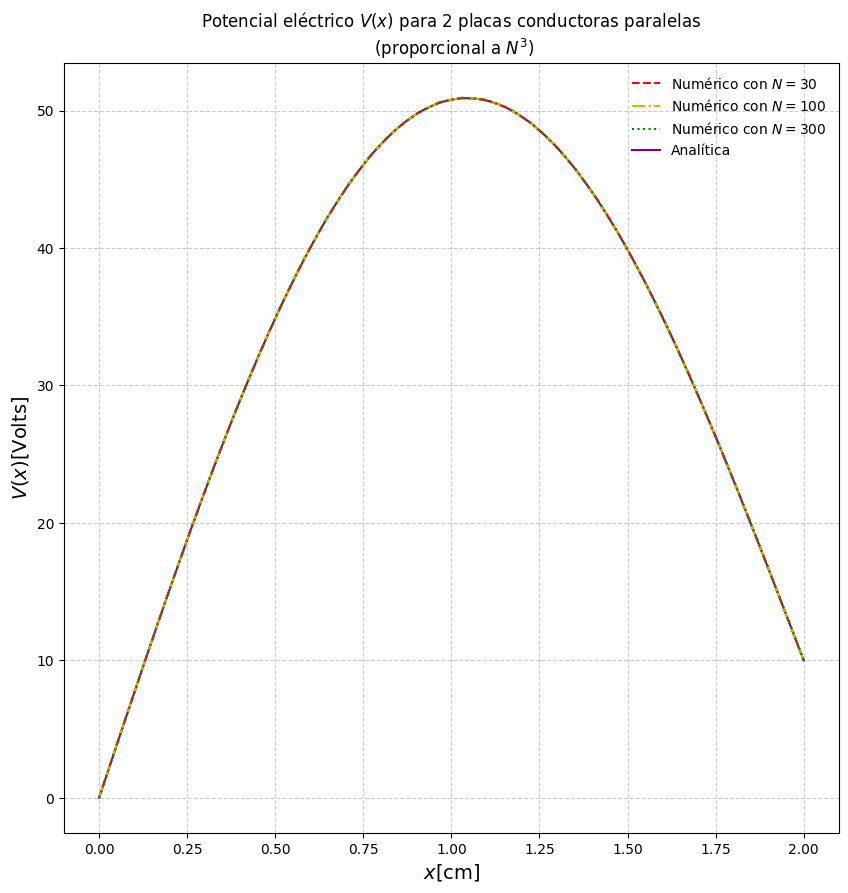

In [3]:
plt.figure(figsize = (10,10))
plt.title('Potencial eléctrico ${V}({x})$ para 2 placas conductoras paralelas \n (proporcional a $N^3$)')
plt.xlabel("${x} $[cm]", fontsize=14)
plt.ylabel("${V}({x}) $[Volts]", fontsize=14)

N_styles = [(30, 'red', '--'), (100, 'orange', '-.'), (300, 'green', ':')]

for (n, c, l) in N_styles:
    # Graficamos las soluciones v(x) para distintos N
    plt.plot(gauss_elimination(n, 'standard')[0]*100, 
             gauss_elimination(n, 'standard')[2], 
             color = c, 
             ls = l, 
             label = 'Numérico con $N = ' + str(n) + '$', 
             zorder = 2)
    
x_300 = gauss_elimination(300, 'standard')[0]
plt.plot(x_300*100, 
         analytic_sol(x_300, D, rho_0, e_0, Va, Vb), 
         color = 'purple', 
         label = 'Analítica', 
         zorder = 1)
plt.legend(loc='upper right', frameon=False)
plt.grid(True, ls = '--', c = 'k', alpha = 0.2)
plt.show()

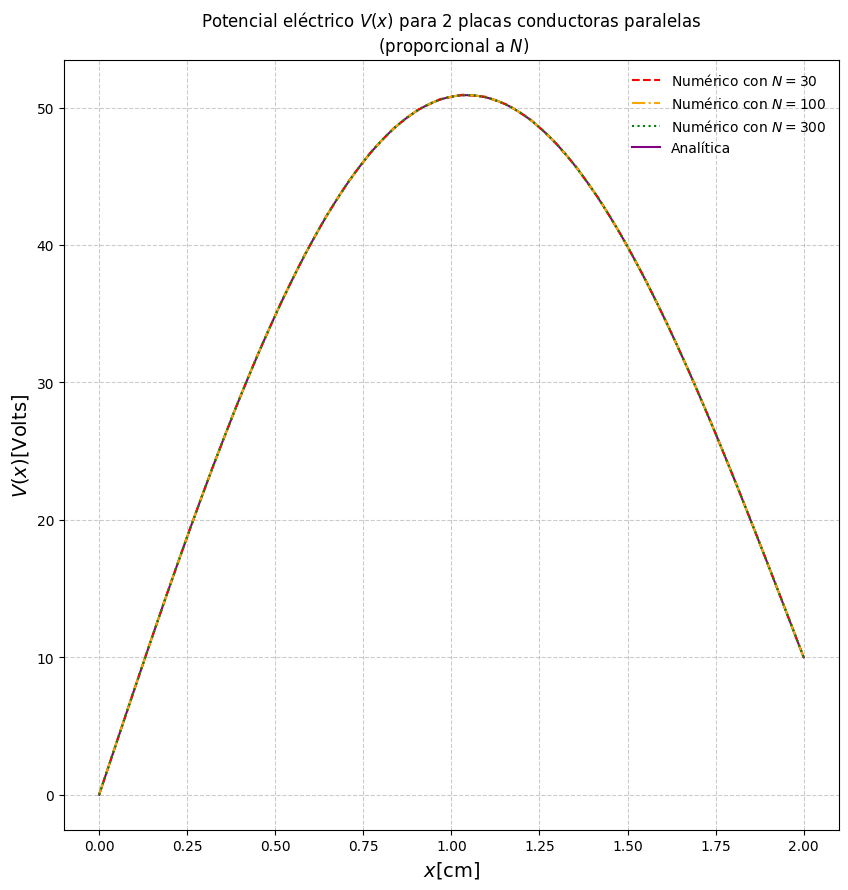

In [4]:
plt.figure(figsize = (10,10))
plt.title('Potencial eléctrico ${V}({x})$ para 2 placas conductoras paralelas \n (proporcional a $N$)')
plt.xlabel("${x} $[cm]", fontsize=14)
plt.ylabel("${V}({x}) $[Volts]", fontsize=14)

N_styles = [(30, 'red', '--'), (100, 'orange', '-.'), (300, 'green', ':')]

for (n, c, l) in N_styles:
    # Graficamos las soluciones v(x) para distintos N
    plt.plot(gauss_elimination(n, 'modified')[0]*100, 
             gauss_elimination(n, 'modified')[2], 
             color = c, 
             ls = l, 
             label = 'Numérico con $N = ' + str(n) + '$', 
             zorder = 2)
    
x_300 = gauss_elimination(300, 'modified')[0]
plt.plot(x_300*100, 
         analytic_sol(x_300, D, rho_0, e_0, Va, Vb), 
         color = 'purple', 
         label = 'Analítica', 
         zorder = 1)
plt.legend(loc='upper right', frameon=False)
plt.grid(True, ls = '--', c = 'k', alpha = 0.2)
plt.show()

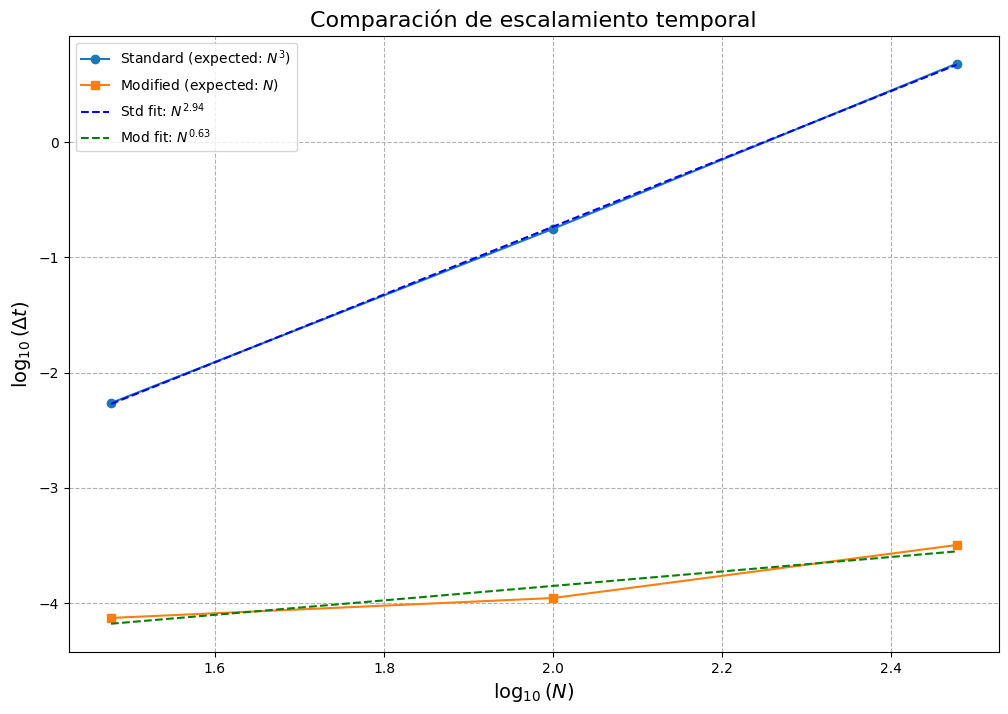

In [6]:
from numpy.polynomial.polynomial import polyfit

ts_std = []
ts_mod = []

N_higher = [30, 100, 300]

for i in N_higher:
    _, _, _, tstd = gauss_elimination(i, method = 'standard')
    _, _, _, tmod = gauss_elimination(i, method = 'modified')
    
    ts_std.append(tstd)
    ts_mod.append(tmod)

log_N = np.log10(N_higher)
log_dt_std = np.log10(ts_std)
log_dt_mod = np.log10(ts_mod)

b_std, a_std = polyfit(log_N, log_dt_std, 1)
b_mod, a_mod = polyfit(log_N, log_dt_mod, 1)

plt.figure(figsize=(12, 8))
plt.plot(log_N, log_dt_std, 'o-', label='Standard (expected: $N^3$)')
plt.plot(log_N, log_dt_mod, 's-', label='Modified (expected: $N$)')

# Add regression lines
plt.plot(log_N, a_std * log_N + b_std, '--', color='blue', label=f'Std fit: $N^{{{a_std:.2f}}}$')
plt.plot(log_N, a_mod * log_N + b_mod, '--', color='green', label=f'Mod fit: $N^{{{a_mod:.2f}}}$')

plt.xlabel("$\\log_{10}(N)$", fontsize=14)
plt.ylabel("$\\log_{10}(\\Delta t)$", fontsize=14)
plt.title("Comparación de escalamiento temporal", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--')
plt.show()